With this notebook you can subselect TeV sources for the stacked analysis of the catalog and rank TeV sources for the IGMF analysis

# Imports

In [1]:
import os
import sys
from collections import OrderedDict

import yaml

import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack

from haloanalysis.utils import create_mask, load_source_rows
from haloanalysis.sed import HaloSED
from haloanalysis.model import CascModel, CascLike
from haloanalysis.model import scan_igmf_likelihood
from haloanalysis.sed import SED

from ebltable.tau_from_model import OptDepth
from haloanalysis.utils import create_mask

In [2]:
import re

In [3]:
%matplotlib inline

# Loading the FHES catalog

In [4]:
cat = '../data/table_std_psf0123_joint2a_stdmodel_cat_v15.fits'

In [5]:
t = Table.read(cat, hdu = 'CATALOG')

### Performing cuts to define samples for stacked analysis

In [6]:
mask_str = [
        {'HBL' : ' (nupeak > 1e15 ) & (var_index < 100.)'},
        {'HBL $z < 0.2$' : ' (nupeak > 1e15 ) & (var_index < 100.) & (redshift <= 0.2)'},
        {'XHBL' : '  (nupeak > 1e17 ) & (var_index < 100.) & (3lac_fx_fr > 1e4)'},
        {'LBL $z > 0.5$' : '  (nupeak <= 1e13 ) & (redshift > 0.5) & (3lac_fx_fr < 1e4)'}
        ]

In [7]:
mask = []
for m in mask_str:
    mask.append(create_mask(t,m))
    print 'surviving sources', np.sum(mask[-1])

Cutting on expression  (tab['nupeak'] > 1e15 ) & (tab['var_index'] < 100.)
surviving sources 402
Cutting on expression  (tab['nupeak'] > 1e15 ) & (tab['var_index'] < 100.) & (tab['redshift'] <= 0.2)
surviving sources 68
Cutting on expression   (tab['nupeak'] > 1e17 ) & (tab['var_index'] < 100.) & (tab['3lac_fx_fr'] > 1e4)
surviving sources 25
Cutting on expression   (tab['nupeak'] <= 1e13 ) & (tab['redshift'] > 0.5) & (tab['3lac_fx_fr'] < 1e4)
surviving sources 54


/u/gl/mmeyer/projects/python/haloanalysis/haloanalysis/utils.py:1: RuntimeWarning: invalid value encountered in greater
  import copy
/u/gl/mmeyer/projects/python/haloanalysis/haloanalysis/utils.py:1: RuntimeWarning: invalid value encountered in less
  import copy
/u/gl/mmeyer/projects/python/haloanalysis/haloanalysis/utils.py:1: RuntimeWarning: invalid value encountered in less_equal
  import copy


Show the redshift distributions after the cuts:

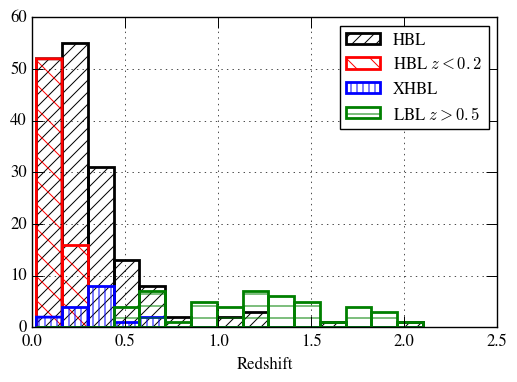

In [8]:
color = ['k','r','b','g']
hatch = ['//','\\','||','-']
#t['redshift'][np.isnan(t['redshift'])] = np.ones(np.sum(np.isnan(t['redshift']))) * -0.1
for i,m in enumerate(mask):
    if not i:
        n,bins, patches = plt.hist(t['redshift'][m & np.isfinite(t['redshift'])], 
                               bins = 15, normed = False, stacked = False, #range = (-0.1,2.5), 
                                   label = mask_str[i].keys()[0],
                                  edgecolor = color[i], facecolor = 'None', lw = 2, hatch = hatch[i])
    else:
        n,bins, patches = plt.hist(t['redshift'][m& np.isfinite(t['redshift'])], 
                               bins = bins, normed = False, stacked = False, label = mask_str[i].keys()[0],
                                  edgecolor = color[i], facecolor = 'None', lw = 2, hatch = hatch[i])

plt.grid(True)
plt.legend(loc=0)
plt.xlabel('Redshift')
plt.savefig('redshift_dist_mask.png', format = 'png', dpi = 200)

# Loading the TeV sources 

In [9]:
tau = OptDepth.readmodel(model = 'dominguez')

In [10]:
cat_tev = Table.read('../data/CompiledTeVSources.fits')

add suffix 3FGL to TeV catalog:

In [11]:
for i,n in enumerate(cat_tev['3FGL_NAME']):
    cat_tev['3FGL_NAME'][i] = '3FGL ' + n

make a table with 3FGL names and their var index and join with tev table

In [12]:
tfhes_var = Table([t['name_3fgl'],t['var_index']], names = ['3FGL_NAME', 'var_index'])

In [13]:
cat_tev = join(cat_tev,tfhes_var)

Get the optical depth

In [14]:
m = np.isfinite(cat_tev['E_REF'].data) 
taus = []
for i,z in enumerate(cat_tev['REDSHIFT'].data):
    taus.append(tau.opt_depth(z,cat_tev['E_REF'].data[i,m[i]]))
taus = np.array(taus)

In [15]:
tau_max = np.array([tm[-1] for tm in taus])

Cuts on the TeV catalog:

In [16]:
c = {'var_zsafe' : '(IS_REDSHIFT_SAFE == 1) & (var_index < 100)'}
mtev = create_mask(cat_tev,c )

Cutting on expression (tab['IS_REDSHIFT_SAFE'] == 1) & (tab['var_index'] < 100)


In [17]:
mtev = (tau_max > 2.) & mtev

Remove sources by hand, e.g. because of variability, not well constrained redshift, etc.

In [18]:
for i,n in enumerate(cat_tev['SOURCE_FULL'].data):
    # remove sources with only LL on z:
    if n.find('1553') >= 0 or n.find('1424') >= 0: mtev[i] = False
    # remove highly variable sources -- this should be clearer defined
    #if n.find('279') >= 0 or n.find('2155') >= 0 or n.lower().find('mkn') >= 0: mtev[i] = False
    # fit fails:
    if n.find('0710') >= 0: mtev[i] = False

Remove the rows that fail the cuts from the table:

In [19]:
idx = np.arange(mtev.shape[0], dtype = np.int)[np.invert(mtev)]

In [20]:
cat_tev.remove_rows(idx)

print catalog and save to file

In [22]:
cat_tev.write('../data/TeV_sources_cut_{0:s}.fits'.format(c.keys()[0]), overwrite = True)
print cat_tev

    3FGL_NAME               SOURCE_FULL            ...   var_index  
----------------- -------------------------------- ... -------------
3FGL J0232.8+2016       1ES0229+200_HESS_2005-2006 ... 49.1630897522
3FGL J0232.8+2016    1ES0229+200_VERITAS_2009-2012 ... 49.1630897522
3FGL J0349.2-1158      1ES0347-121_HESS_2006-09-12 ... 44.2567939758
3FGL J0416.8+0104    1ES0414+009_VERITAS_2008-2011 ... 55.8486251831
3FGL J0416.8+0104       1ES0414+009_HESS_2005-2009 ... 55.8486251831
3FGL J1010.2-3120 1RXSJ101015.9-311909_HESS_2006-2 ... 86.2991027832
3FGL J1103.5-2329       1ES1101-232_HESS_2004-2005 ... 36.5130081177
3FGL J1221.3+3010    1ES1218+304_VERITAS_2008-2009 ... 92.4541015625
3FGL J1221.3+3010         1ES1218+304_VERITAS_2007 ... 92.4541015625
3FGL J1314.7-4237       1ES1312-423_HESS_2004-2010 ... 45.0239028931
3FGL J1428.5+4240        H1426+428_HEGRA_1999_2000 ... 59.4608573914
3FGL J1428.5+4240             H1426+428_HEGRA_2002 ... 59.4608573914
3FGL J2359.3-3038              H23

In [1]:
help(np.array)

Help on built-in function array in module numpy.core.multiarray:

array(...)
    array(object, dtype=None, copy=True, order=None, subok=False, ndmin=0)
    
    Create an array.
    
    Parameters
    ----------
    object : array_like
        An array, any object exposing the array interface, an
        object whose __array__ method returns an array, or any
        (nested) sequence.
    dtype : data-type, optional
        The desired data-type for the array.  If not given, then
        the type will be determined as the minimum type required
        to hold the objects in the sequence.  This argument can only
        be used to 'upcast' the array.  For downcasting, use the
        .astype(t) method.
    copy : bool, optional
        If true (default), then the object is copied.  Otherwise, a copy
        will only be made if __array__ returns a copy, if obj is a
        nested sequence, or if a copy is needed to satisfy any of the other
        requirements (`dtype`, `order`, etc.).